- [bentrevett/pytorch-sentiment-analysis](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb)
- [From a LSTM cell to a Multilayer LSTM Network with PyTorch](https://towardsdatascience.com/from-a-lstm-cell-to-a-multilayer-lstm-network-with-pytorch-2899eb5696f3)

# LSTMCell Class from PyTorch


Рассмотрим, как адаптировать реальные входные данные в LSTMClass от PyTorch.

Во-первых, давайте разберемся, каковы параметры ввода-вывода при инициализации LSTMClass и каковы параметры ввода-вывода при использовании инициализированного объекта.

Для инициализации классу LSTMCell необходимы два важных параметра.

input_size: относится к количеству функций для каждого временного шага

hidden_size: относится к количеству параметров, которые должны быть изучены в каждой функции внутри ячейки LSTM (т.е. это размер каждого вектора W, который составляет каждый вентиль, а также ячейку и скрытые состояния)

После инициализации объект, созданный LSTMClass, получает три входа:

- **input**: тензор, который содержит особенности, которые необходимо изучить.Этот тензор имеет форму (`batch`, `input_size`), где пакет относится к размеру `batch`, а `input_size` относится к количеству функций, которые содержатся на каждом временном шаге.

- **h_0**: тензор, который будет хранить изученное скрытое состояние.
Этот тензор имеет форму (`batch`, `hidden_size`)

- **c_0**: тензор, который будет хранить состояние ячейки (память LSTM).
Этот тензор имеет форму (`batch`, `hidden_size`).

На рисунке выделены векторные формы для входа x(t), скрытых состояний h(t-1) и h(t), а также состояний ячейки C(t-1) и C(t).

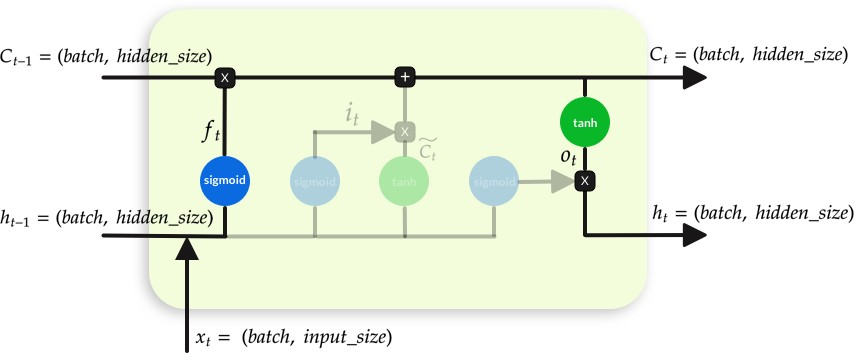

Как мы уже знаем, LSTM работают с последовательными данными.
Итак, давайте разберемся на простом примере, как последовательно  развернуть сеть LSTM.

Предположим, у нас есть предложение «небо голубое», которое мы хотим ввести в LSTM. Итак, нам нужно было бы преобразовать эти слова в читаемый формат для нейронных сетей.

Надо сказать, что существует множество вариантов для преобразования слов в формат, читаемый LSTM, но поскольку эти параметры выходят за рамки этой статьи, мы ограничимся выбором одного из наиболее распространенных вариантов - это токенизация.

Чтобы закодировать слова в LSTM-читаемый формат, нам сначала нужно разделить предложение на набор слов (токены), а затем нам нужно будет преобразовать каждый токен слова в форму индекса-токена. После этого нам нужно будет использовать вектор `embedding`, чтобы преобразовать каждый индекс-токен во встроенный вектор. И нам нужно будет только организовать последовательность векторов в набор временных шагов, где каждому временному шагу будет назначен размер пакета (`batch size`).

Представим, что мы хотим создать набор из 2 временных шагов, где каждый временной шаг содержит размер пакета = 2, у нас будет 2 входных тензора, каждый с формой (`batch_size` = 2, `input_size` = 2), где `batch_size` относится к количеству выборок на временном шаге, а `input_size` относится к размеру 'embedding`.

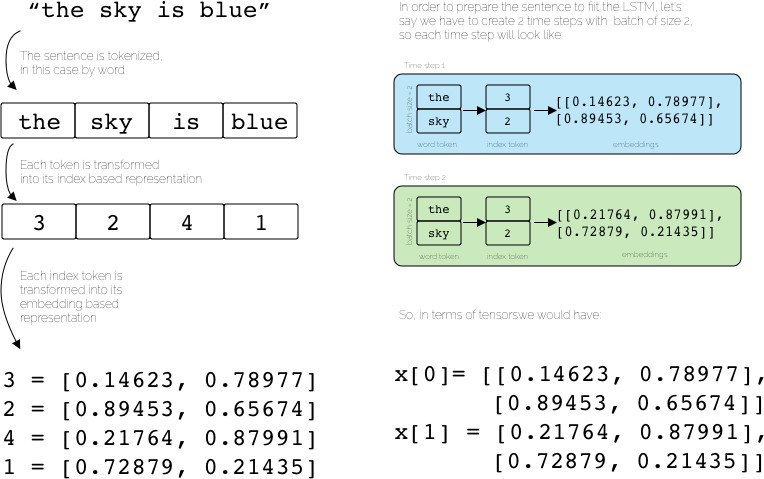

Чтобы снабжать сеть LSTM последовательными данными, нам нужно создать цикл, в котором каждая итерация будет передавать в текущую ячейку LSTM с шагом с размерностью (`shape`) (`batch_size`, `input_size`). С точки зрения предыдущего примера, каждый временной шаг будет содержать размер пакета, равный 2, и размер ввода, равный 2 (`batch size=2` and `input size=2`).

На рисунке верхняя схема показывает использование словарных токенов, среднее изображение - использование представления на основе индексов-токенов, а изображение внизу - использование представления на основе `embedding`.

(Три изображения эквивалентны, верхнее и среднее изображения служат только для лучшего понимания).

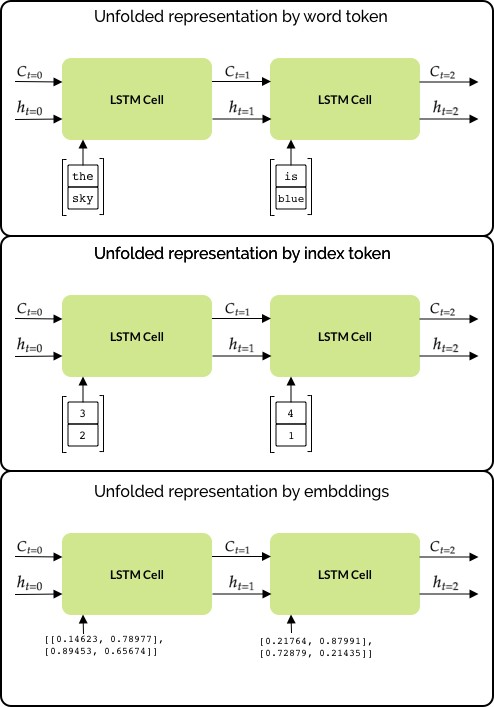

Посмотрим ниже, как реализуется эта схема на практике на примере анализа тональности отзывов о фильмах.

# Простой Sentiment Analysis

## Preparing Data
Мы будем использовать `packed padded sequences`, что заставит нашу RNN обрабатывать только незаполненные элементы нашей последовательности, и для любого дополненного элемента вывод будет нулевым тензором.

Чтобы использовать *packed padded sequencesи*, мы должны сообщить RNN, какова длина фактических последовательностей.

Мы делаем это, устанавливая `include_lengths = True` для нашего поля `TEXT`.

Это приведет к тому, что `batch.text` теперь будет кортежем, первый элемент которого будет нашим предложением (числовой тензор, который был дополнен), а второй элемент будет фактической длиной наших предложений.

Одна из основных концепций TorchText - это `Field` (поле).
Они определяют, как ваши данные должны обрабатываться. В нашей задаче классификации тональности данные состоят как из необработанной строки отзыва, так и из настроения, либо «положительного», либо «отрицательного».

Параметры `Field` определяют, как данные должны обрабатываться.

Поле `TEXT`, используется, чтобы определить, как следует обрабатывать отзыв, и поле `LABEL`, чтобы обработать мнение. В нашем поле `TEXT` в качестве аргумента указано `tokenize='spacy'`. Это определяет, что «токенизация» (действие разделения строки на дискретные «токены») должна выполняться с использованием токенизатора [spaCy](https://spacy.io).

Если аргумент `tokenize` не передан, по умолчанию строка просто разбивается на пробелы. Нам также нужно указать `tokenizer_language`, который сообщает torchtext, какую модель spaCy использовать. Мы используем модель `en_core_web_sm`, которую необходимо загрузить с помощью `python -m spacy download en_core_web_sm` перед запуском этого ноутбука!

`LABEL` определяется `LabelField`, специальным подмножеством класса `Field`, специально используемым для обработки меток. Мы объясним аргумент dtype позже.

Чтобы узнать больше о `Field`, перейдите [сюда](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).

Мы также устанавливаем случайные начальные числа для функции `random`.

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
# загружаем набор данных IMDb
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

В наборе данных `IMDb` есть только разделение на поезд / тест, поэтому нам нужно создать набор проверки.

Мы также передаем наше случайное начальное значение аргументу `random_state`, гарантируя, что каждый раз мы получаем одно и то же разделение на поезд / проверку.

In [ ]:
import random
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Вот так выглядит токенизированный текст:

In [ ]:
print(vars(train_data.examples[0]))

Далее нам нужно создать СЛОВАРЬ.

Это фактически справочная таблица, в которой каждое уникальное слово в вашем наборе данных имеет соответствующий `_index_` (целое число). Мы делаем это, поскольку наша модель машинного обучения не может работать со строками, а только с числами. Каждый `_index_` используется для построения `_one-hot_` для каждого слова.

`_one-hot_` - это вектор, в котором все элементы равны 0, кроме одного, равного 1, а размерность - это общее количество уникальных слов в вашем словаре, обычно обозначаемое $V$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment5.png?raw=1)

Количество уникальных слов в нашем обучающем наборе превышает 100 000, а это значит, что наши горячие векторы будут иметь более 100 000 измерений! Это замедлит обучение и, возможно, не поместится на вашем GPU (если вы его используете).

Есть два способа эффективно сократить наш словарный запас: мы можем взять только $n$ самых распространенных слов или игнорировать слова, которые встречаются менее $m$ раз. Мы сделаем первое, оставив только первые 25 000 слов.

Что нам делать со словами, которые появляются в примерах, но которые мы вырезали из словарного запаса? Мы заменяем их специальным токеном `_unknown_` или `<unk>`. Например, если предложение было "This film is great and I love it", но слова "love" не было в лексиконе, оно превратилось бы в «Этот фильм отличный, и я его `<unk>` (не знаю).

Следующее создает словарь, сохраняя только наиболее распространенные токены `max_size`.

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

Почему мы формируем словарный запас только на обучающей выборке?

При тестировании любой системы машинного обучения вы ни в коем случае не должны смотреть на тестовую выборку! А проверку проводим на валидационной.

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Почему размер словаря 25002, а не 25000? Один из дополнительных токенов - это токен `<unk>`, а другой - токен `<pad>`.

Когда мы вводим предложения в нашу модель, мы загружаем их по партии за раз, то есть по нескольку за раз, и все предложения в пакете должны быть одного размера. Таким образом, чтобы гарантировать, что каждое предложение в `_batch_ ` имеет одинаковый размер, любое предложение короче самого длинного в пакете дополняется.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment6.png?raw=1)

Мы также можем просмотреть наиболее часто встречающиеся слова в словаре и их частоту:

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

И мы можем посмотреть на сам словарь, используя методы `stoi` (**s**tring **to** **i**nt) или `itos` (**i**nt **to**  **s**tring):

In [ ]:
print(TEXT.vocab.itos[:10])

Мы также можем проверить метки, убедившись, что 0 соответствует отрицательному значению, а 1 - положительному:

In [ ]:
print(LABEL.vocab.stoi)

Последний шаг подготовки данных - создание итераторов (iterators). Мы будем повторять их в цикле training/evaluation, и они будут возвращать пакет примеров (проиндексированных и преобразованных в тензоры) при каждой итерации.

Мы будем использовать `BucketIterator`, который представляет собой особый тип итератора, который будет возвращать пакет примеров, каждый из которых имеет одинаковую длину, минимизируя количество отступов для каждого примера.

As before, we create the iterators, placing the tensors on the GPU if one is available.

Another thing for packed padded sequences all of the tensors within a batch need to be sorted by their lengths. This is handled in the iterator by setting `sort_within_batch = True`.

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device =', device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Build the Model

### Long Short-Term Memory (LSTM) Architecture

We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM). Why is an LSTM better than a standard RNN? Standard RNNs suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple _gates_ which control the flow of information into and out of the memory. For more information, go [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). We can simply think of the LSTM as a function of $x_t$, $h_t$ and $c_t$, instead of just $x_t$ and $h_t$.

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

Thus, the model using an LSTM looks something like (with the embedding layers omitted):

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment2.png?raw=1)

The initial cell state, $c_0$, like the initial hidden state is initialized to a tensor of all zeros. The sentiment prediction is still, however, only made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

### Bidirectional RNN

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the **last to the first** (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$. 

In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor. 

We make our sentiment prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), $h_T^\rightarrow$, and the last hidden state from the backward RNN (obtained from the first word of the sentence), $h_T^\leftarrow$, i.e. $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$   

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver.  

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment3.png?raw=1)

### Multi-layer RNN

Multi-layer RNNs (also called *deep RNNs*) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another *layer*. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment4.png?raw=1)

### Regularization

Although we've added improvements to our model, each one adds additional parameters. Without going into overfitting into too much detail, the more parameters you have in in your model, the higher the probability that your model will overfit (memorize the training data, causing  a low training error but high validation/testing error, i.e. poor generalization to new, unseen examples). To combat this, we use regularization. More specifically, we use a method of regularization called *dropout*. Dropout works by randomly *dropping out* (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model. The predictions from all these "weaker" models (one for each forward pass) get averaged together withinin the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.

### Implementation Details

Another addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state. 

As the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the `nn.Linear` layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the `num_layers` and `bidirectional` arguments for the RNN/LSTM. 

Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to. **Note**: never use dropout on the input or output layers (`text` or `fc` in this case), you only ever want to use dropout on intermediate layers. The LSTM has a `dropout` argument which adds dropout on the connections between hidden states in one layer to hidden states in the next layer. 

As we are passing the lengths of our sentences to be able to use packed padded sequences, we have to add a second argument, `text_lengths`, to `forward`. 

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the `hidden` and `cell` states (both of which are tensors). Without packed padded sequences, `hidden` and `cell` are tensors from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. Note that the `lengths` argument of `packed_padded_sequence` must be a CPU tensor so we explicitly make it one by using `.to('cpu')`.

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of `output` from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

The final hidden state, `hidden`, has a shape of _**[num layers * num directions, batch size, hid dim]**_. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
             EMBEDDING_DIM, 
             HIDDEN_DIM, 
             OUTPUT_DIM, 
             N_LAYERS, 
             BIDIRECTIONAL, 
             DROPOUT, 
             PAD_IDX)

We'll print out the number of parameters in our model.
Notice how we have almost twice as many parameters as before!

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

As our `<unk>` and `<pad>` token aren't in the pre-trained vocabulary they have been initialized using `unk_init` (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment. 

We do this by manually setting their row in the embedding weights matrix to zeros. We get their row by finding the index of the tokens, which we have already done for the padding index.

**Note**: like initializing the embeddings, this should be done on the `weight.data` and not the `weight`!

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

In [ ]:
emb = model.embedding.weight.data
emb.shape

We can now see the first two rows of the embedding weights matrix have been set to zeros. As we passed the index of the pad token to the `padding_idx` of the embedding layer it will remain zeros throughout training, however the `<unk>` token embedding will be learned.

## Train the Model

Now to training the model.

The only change we'll make here is changing the optimizer from `SGD` to `Adam`. SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. `Adam` adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. More information about `Adam` (and other optimizers) can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To change `SGD` to `Adam`, we simply change `optim.SGD` to `optim.Adam`, also note how we do not have to provide an initial learning rate for Adam as PyTorch specifies a sensibile default initial learning rate.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

The rest of the steps for training the model are unchanged.

We define the criterion and place the model and criterion on the GPU (if available)...

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model. 

As we have set `include_lengths = True`, our `batch.text` is now a tuple with the first element being the numericalized tensor and the second element being the actual lengths of each sequence. We separate these into their own variables, `text` and `text_lengths`, before passing them to the model.

**Note**: as we are now using dropout, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

The `train` function iterates over all examples, one batch at a time. 

`model.train()` is used to put the model in "training mode", which turns on _dropout_ and _batch normalization_. Although we aren't using them in this model, it's good practice to include it.

For each batch, we first zero the gradients. Each parameter in a model has a `grad` attribute which stores the gradient calculated by the `criterion`. PyTorch does not automatically remove (or "zero") the gradients calculated from the last gradient calculation, so they must be manually zeroed.

We then feed the batch of sentences, `batch.text`, into the model. Note, you do not need to do `model.forward(batch.text)`, simply calling the model works. The `squeeze` is needed as the predictions are initially size _**[batch size, 1]**_, and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size _**[batch size]**_.

The loss and accuracy are then calculated using our predictions and the labels, `batch.label`, with the loss being averaged over all examples in the batch.

We calculate the gradient of each parameter with `loss.backward()`, and then update the parameters using the gradients and optimizer algorithm with `optimizer.step()`.

The loss and accuracy is accumulated across the epoch, the `.item()` method is used to extract a scalar from a tensor which only contains a single value.

Finally, we return the loss and accuracy, averaged across the epoch. The `len` of an iterator is the number of batches in the iterator.

You may recall when initializing the `LABEL` field, we set `dtype=torch.float`. This is because TorchText sets tensors to be `LongTensor`s by default, however our criterion expects both inputs to be `FloatTensor`s. Setting the `dtype` to be `torch.float`, did this for us. The alternative method of doing this would be to do the conversion inside the `train` function by passing `batch.label.float()` instad of `batch.label` to the criterion. 

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Then we define a function for testing our model, again remembering to separate `batch.text`.

**Note**: as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

`evaluate` is similar to `train`, with a few modifications as you don't want to update the parameters when evaluating.

`model.eval()` puts the model in "evaluation mode", this turns off _dropout_ and _batch normalization_. Again, we are not using them in this model, but it is good practice to include them.

No gradients are calculated on PyTorch operations inside the `with no_grad()` block. This causes less memory to be used and speeds up computation.

The rest of the function is the same as `train`, with the removal of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as we do not update the model's parameters when evaluating.

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

And also create a nice function to tell us how long our epochs are taking.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

...and get our new and vastly improved test accuracy!

In [ ]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## User Input

We can now use our model to predict the sentiment of any sentence we give it. As it has been trained on movie reviews, the sentences provided should also be movie reviews.

When using a model for inference it should always be in evaluation mode. If this tutorial is followed step-by-step then it should already be in evaluation mode (from doing `evaluate` on the test set), however we explicitly set it to avoid any risk.

Our `predict_sentiment` function does a few things:
- sets the model to evaluation mode
- tokenizes the sentence, i.e. splits it from a raw string into a list of tokens
- indexes the tokens by converting them into their integer representation from our vocabulary
- gets the length of our sequence
- converts the indexes, which are a Python list into a PyTorch tensor
- add a batch dimension by `unsqueeze`ing 
- converts the length into a tensor
- squashes the output prediction from a real number between 0 and 1 with the `sigmoid` function
- converts the tensor holding a single value into an integer with the `item()` method

We are expecting reviews with a negative sentiment to return a value close to 0 and positive reviews to return a value close to 1.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

An example negative review...

In [ ]:
predict_sentiment(model, "This film is terrible")

An example positive review...

In [ ]:
predict_sentiment(model, "This film is great")

И, скорее негатиынй, чем позитивный отзыв:

In [ ]:
predict_sentiment(model, "So so") 